In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2
import os

In [23]:
IMG_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3

In [24]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "E:\Plant Leaf Disease Prediction Resources\Dataset\subset(96%)",
    labels = 'inferred',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 4925 files belonging to 13 classes.


In [25]:
classes = data.class_names

In [26]:
len(data)

154

In [27]:
for img_batch, label_batch in data.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 7  8  7 12  4  5  3  8  3  6  8  2 12  3  4 10  1  4 10  8 10 10 11  7
  7  5  3  7  8 10  4  9]


In [28]:
for img_batch, label_batch in data.take(1):
    print(img_batch[0].shape)

(256, 256, 3)


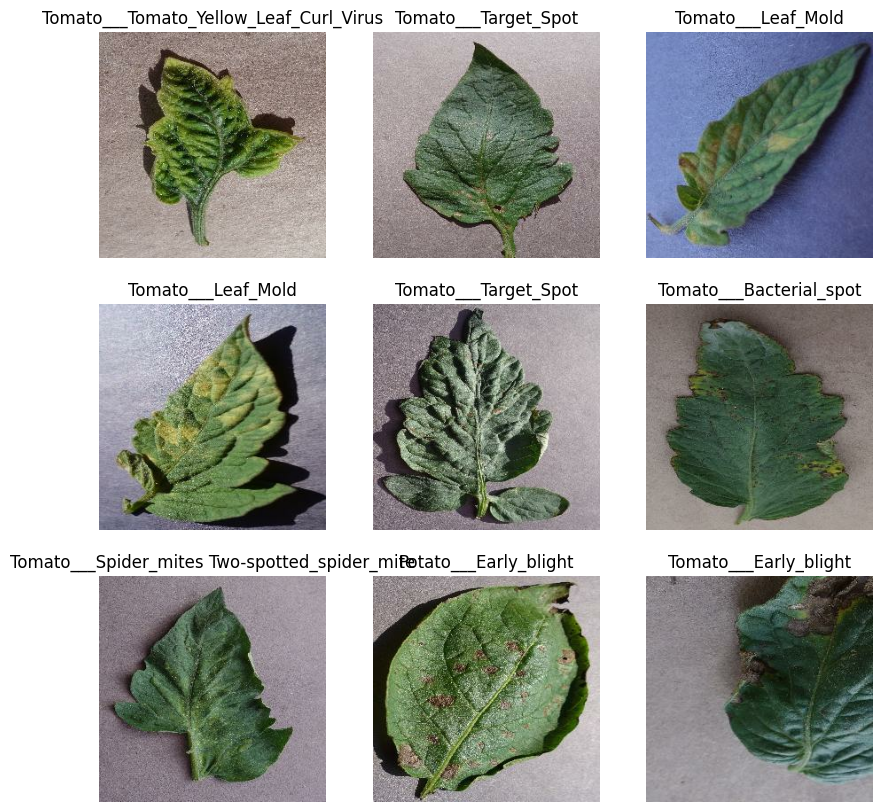

In [29]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        plt.title(classes[label_batch[i].numpy()])
        plt.axis('off')

In [30]:
def prepare_datasets(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2000):
    size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size)

    train_size = int(size*train_split)
    val_size = int(size*val_split)

    train_data = data.take(train_size)
    rem_data = data.skip(train_size)
    val_data = rem_data.take(val_size)
    test_data = rem_data.skip(val_size)

    return train_data, val_data, test_data

In [31]:
train_data, val_data, test_data = prepare_datasets(data)

In [32]:
print(len(train_data), len(val_data), len(test_data))
print(len(data))

123 15 16
154


In [33]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
preprocess_image = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
        tf.keras.layers.Rescaling(1./255)
    ]
)

In [35]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2)
    ]
)

In [36]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 13

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
base_model.trainable = False

model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% training accuracy, stopping training.")
            self.model.stop_training = True

stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.92)

In [39]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=25,
    callbacks=[stop_training_callback]
)

Epoch 1/25
123/123 [==============================] - 128s 917ms/step - loss: 2.3556 - accuracy: 0.2048 - val_loss: 1.8601 - val_accuracy: 0.4833
Epoch 2/25
123/123 [==============================] - 84s 680ms/step - loss: 1.7204 - accuracy: 0.4289 - val_loss: 1.2546 - val_accuracy: 0.6438
Epoch 3/25
123/123 [==============================] - 83s 677ms/step - loss: 1.3546 - accuracy: 0.5488 - val_loss: 1.0215 - val_accuracy: 0.6958
Epoch 4/25
123/123 [==============================] - 83s 672ms/step - loss: 1.1207 - accuracy: 0.6423 - val_loss: 0.8129 - val_accuracy: 0.7417
Epoch 5/25
123/123 [==============================] - 84s 682ms/step - loss: 0.9403 - accuracy: 0.6977 - val_loss: 0.6809 - val_accuracy: 0.7667
Epoch 6/25
123/123 [==============================] - 82s 664ms/step - loss: 0.8503 - accuracy: 0.7297 - val_loss: 0.6241 - val_accuracy: 0.8083
Epoch 7/25
123/123 [==============================] - 82s 668ms/step - loss: 0.7389 - accuracy: 0.7696 - val_loss: 0.5593 - val_a

In [40]:
model.evaluate(test_data)

16/16 [==============================] - 27s 620ms/step - loss: 0.2396 - accuracy: 0.9375


[0.23962754011154175, 0.9375]

Actual label:  Potato___Late_blight
1/1 [==============================] - 2s 2s/step
Predicted label:  Potato___Late_blight


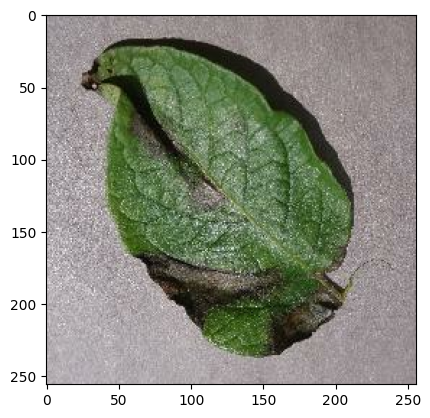

In [41]:
for img_batch, label_batch in test_data.take(1):
    first_image = img_batch[0].numpy().astype('int')
    first_label = label_batch[0].numpy()
    print("Actual label: ", classes[first_label])
    pred = model.predict(img_batch)
    print("Predicted label: ", classes[np.argmax(pred[0])])
    plt.imshow(first_image)

1/1 [==============================] - 0s 57ms/step


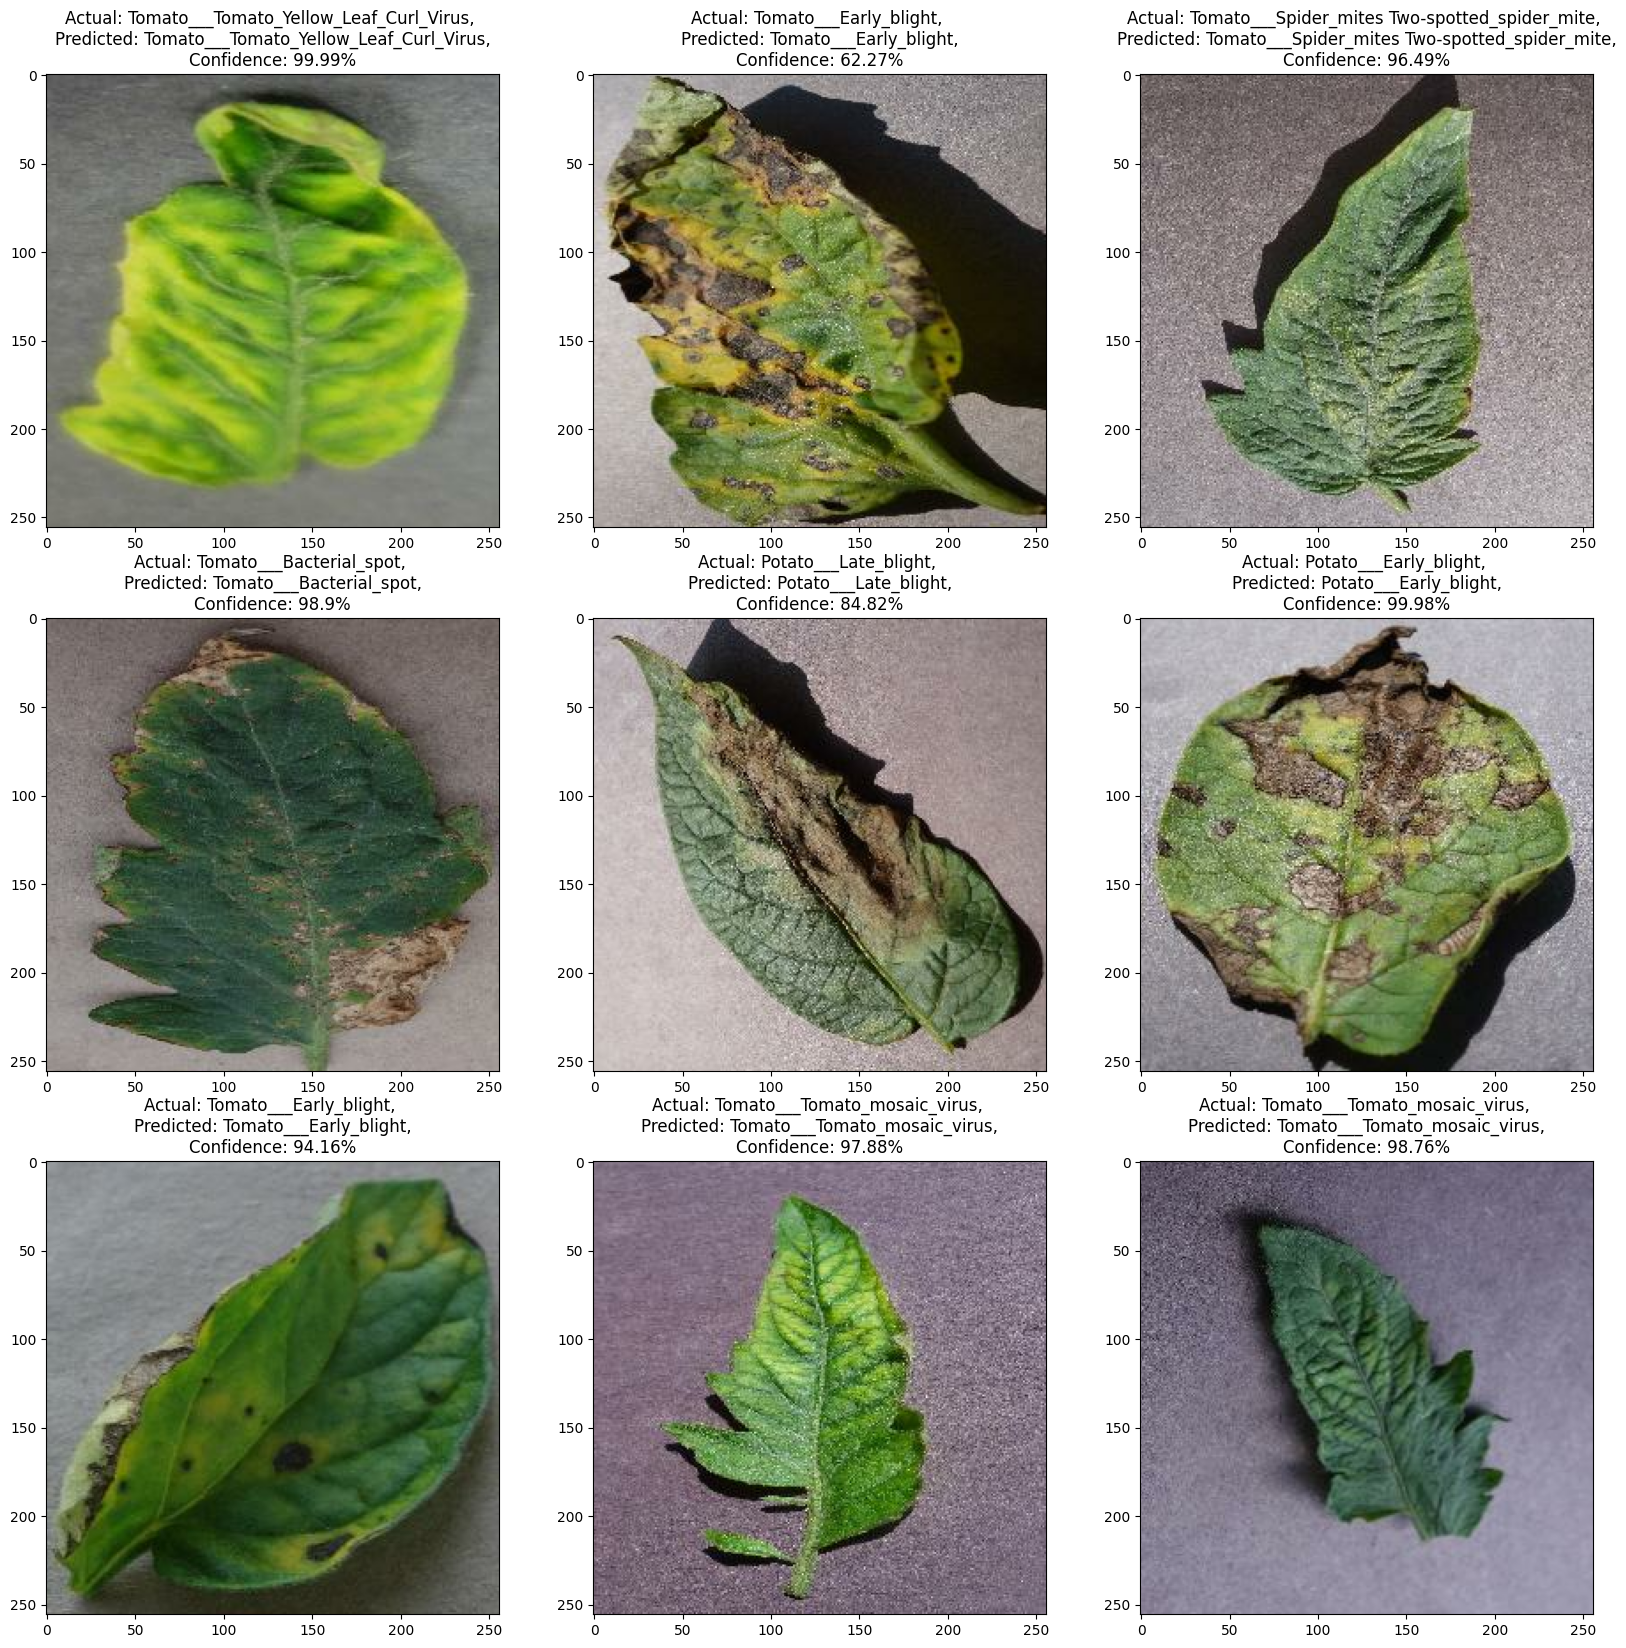

In [44]:
def predict(model, img):
    img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis=0)
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(20, 20))
for img_batch, label_batch in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        predicted_class, confidence = predict(model, img_batch[i])
        actual_class = classes[label_batch[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\nConfidence: {confidence}%")

In [ ]:
model_version = 1
os.makedirs("E:/Plant-Leaf-Disease-Prediction/models_h5", exist_ok=True)
model.save(f"E:/Plant-Leaf-Disease-Prediction/models_h5/model_v{model_version}.h5")

In [ ]:
model_version = 2
model.save(f"E:/Plant-Leaf-Disease-Prediction/models_h5/model_v{model_version}.h5")

In [ ]:
model_version = 3
model.save(f"E:/Plant-Leaf-Disease-Prediction/models_h5/model_v{model_version}.h5")